In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

/tmp/ipykernel_50024/4165436749.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-19 09:22:50.896766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 09:22:50.930288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 09:22

In [2]:
#Get all unique tiles
all_filenames=glob.glob("/cloud/KappaZeta/L1C/*/*/*")
all_tiles=[]
for name in all_filenames:
    cur_tile=name.split('/')[-1]
    exist_count=0
    for tile in all_tiles:
        if tile==cur_tile:
            exist_count+=1
            break
    if exist_count==0: #Only append if not appended already
        all_tiles.append(cur_tile)

In [3]:
cur_tile=all_tiles[6]
paths="/cloud/KappaZeta/L1C/*/*/*/*"+cur_tile+".nc"
filenames=glob.glob(paths)
samples=[]
for filename in filenames:
    samples.append(nc.Dataset(filename))
print("Using "+str(len(samples))+" sample images")

Using 7 sample images


In [4]:
filenames

['/cloud/KappaZeta/L1C/june/S2A_MSIL1C_20200602T092041_N0209_R093_T36VUJ_20200602T104732/tile_3_2/T36VUJ_20200602T092041_tile_3_2.nc',
 '/cloud/KappaZeta/L1C/june/S2A_MSIL1C_20200627T101031_N0209_R022_T33UWT_20200627T111749/tile_3_2/T33UWT_20200627T101031_tile_3_2.nc',
 '/cloud/KappaZeta/L1C/june/S2B_MSIL1C_20200615T101559_N0209_R065_T33VVC_20200615T124248/tile_3_2/T33VVC_20200615T101559_tile_3_2.nc',
 '/cloud/KappaZeta/L1C/april/S2B_MSIL1C_20200412T085549_N0209_R007_T36VWK_20200412T111506/tile_3_2/T36VWK_20200412T085549_tile_3_2.nc',
 '/cloud/KappaZeta/L1C/may/S2A_MSIL1C_20200503T092031_N0209_R093_T35UMQ_20200503T105308/tile_3_2/T35UMQ_20200503T092031_tile_3_2.nc',
 '/cloud/KappaZeta/L1C/october/S2B_MSIL1C_20201001T094039_N0209_R036_T35VMF_20201001T115620/tile_3_2/T35VMF_20201001T094039_tile_3_2.nc',
 '/cloud/KappaZeta/L1C/september/S2B_MSIL1C_20200905T092029_N0209_R093_T35ULR_20200905T103628/tile_3_2/T35ULR_20200905T092029_tile_3_2.nc']

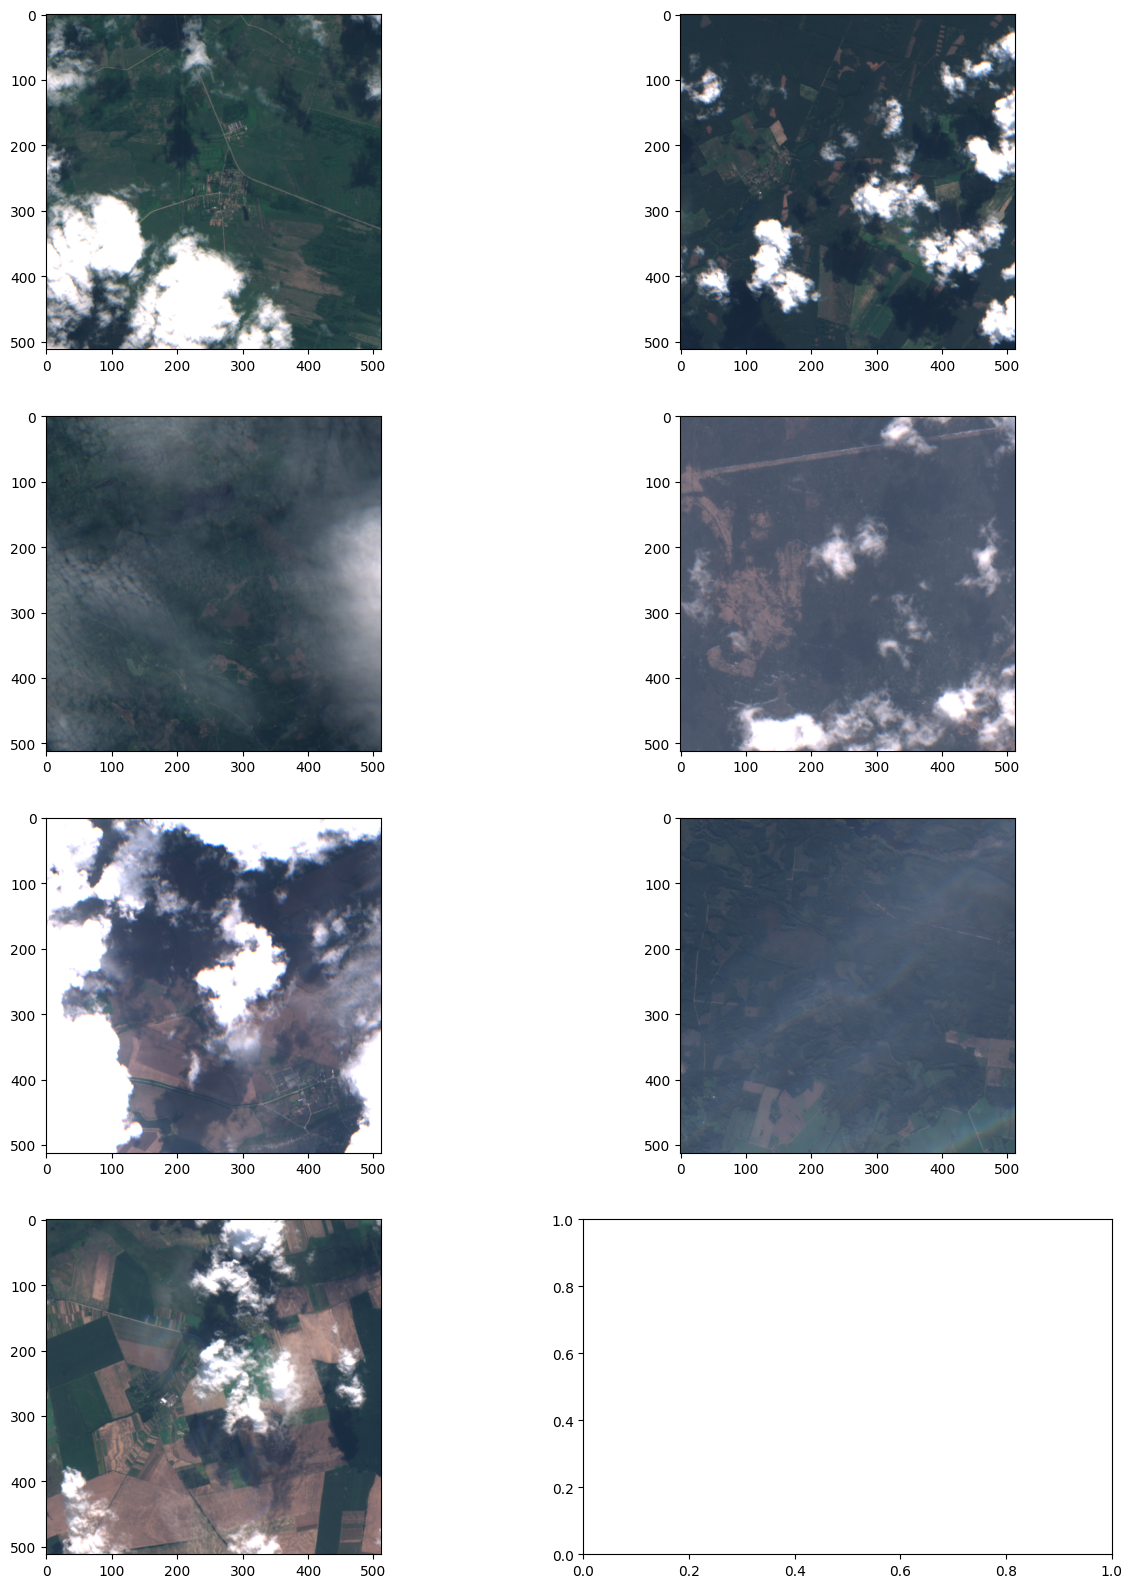

In [5]:
nimages=len(samples)
ncols=2
nrows=int(np.ceil(nimages/2))
plt.rcParams["figure.figsize"] = [15, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    if i < nimages:
        sample=samples[i]
        R=sample.variables['TCI_R'][:].data
        G=sample.variables['TCI_G'][:].data
        B=sample.variables['TCI_B'][:].data
        image=np.zeros((512,512,3))
        image[:,:,0]=R
        image[:,:,1]=G
        image[:,:,2]=B
        image=image/255
        ax.imshow(image)

In [6]:
file=filenames[2]

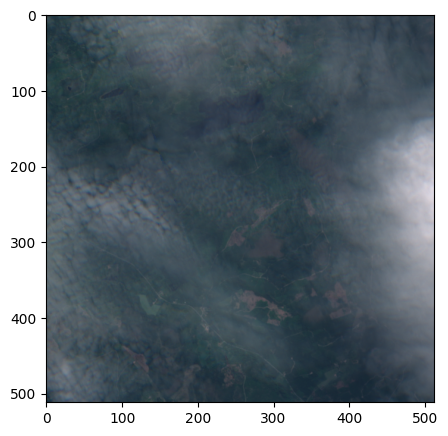

In [7]:
ds=nc.Dataset(file)
R=ds.variables['TCI_R'][:].data
G=ds.variables['TCI_G'][:].data
B=ds.variables['TCI_B'][:].data
image=np.zeros((512,512,3))
image[:,:,0]=R
image[:,:,1]=G
image[:,:,2]=B
image=image/255
plt.rcParams["figure.figsize"] = [5, 5*nrows]
plt.imshow(image)

In [8]:
x_dim=ds.dimensions['x'].size
y_dim=ds.dimensions['y'].size

scaling=1
channels=['B02','B03','B04','B05','B06','B07','B08',
            'B8A','B09','B10','B11','B12']
data=np.zeros((x_dim,y_dim,len(channels)))
in_data=np.zeros((x_dim*y_dim,len(channels)))
for i,channel in enumerate(channels):
    d=ds.variables[channel][:].data*scaling
    data[:,:,i]=d
    in_data[:,i]=np.reshape(d,x_dim*y_dim)


In [9]:
np.max(data,axis=(0,1))

array([0.04924086, 0.04690623, 0.04824903, 0.05224689, 0.06390478,
       0.07722591, 0.07722591, 0.08343633, 0.03656062, 0.00207523,
       0.06465247, 0.05702297])

In [10]:
data=data/np.max(data,axis=(0,1))
in_data=in_data/np.max(in_data,axis=0)

## Cloud Removal

In [15]:
main_filepath='pytorch_models/many_quantiles'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [16]:
#Make predictions
for i,model in enumerate(models):
    if i==0:
        y_pred=model.predict(in_data)
    else:   
        y_pred=y_pred+model.predict(in_data)
y_pred=y_pred/len(models)
img_pred=y_pred[:,:,4] # Get median quantile
#img_pred=in_data-y_pred[:,:,4] # If estimate cloud
img_pred_re=np.reshape(img_pred,(x_dim,y_dim,12))

uncertainty_map=y_pred[:,:,-1]-y_pred[:,:,0]
#uncertainty_map=(in_data-y_pred[:,:,-1])-(in_data-y_pred[:,:,0]) #If cloud estimation
uncertainty_map_re=np.reshape(uncertainty_map,(x_dim,y_dim,12))

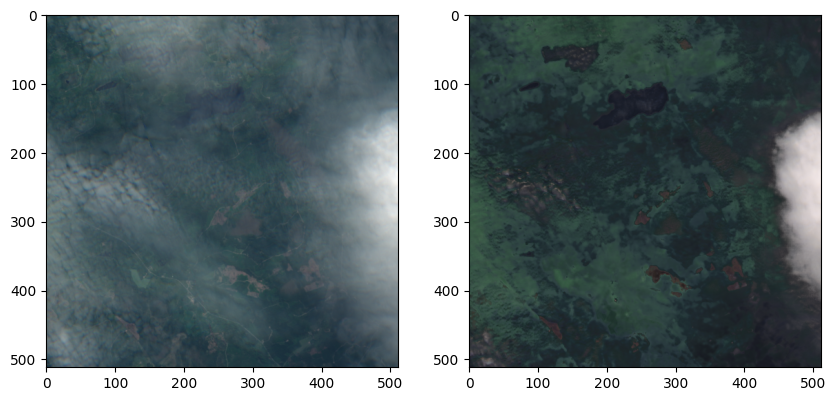

In [17]:
plt.rcParams["figure.figsize"] = [10, 5]
fig, axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(data[:,:,[2,1,0]])
axs[1].imshow(img_pred_re[:,:,[2,1,0]])

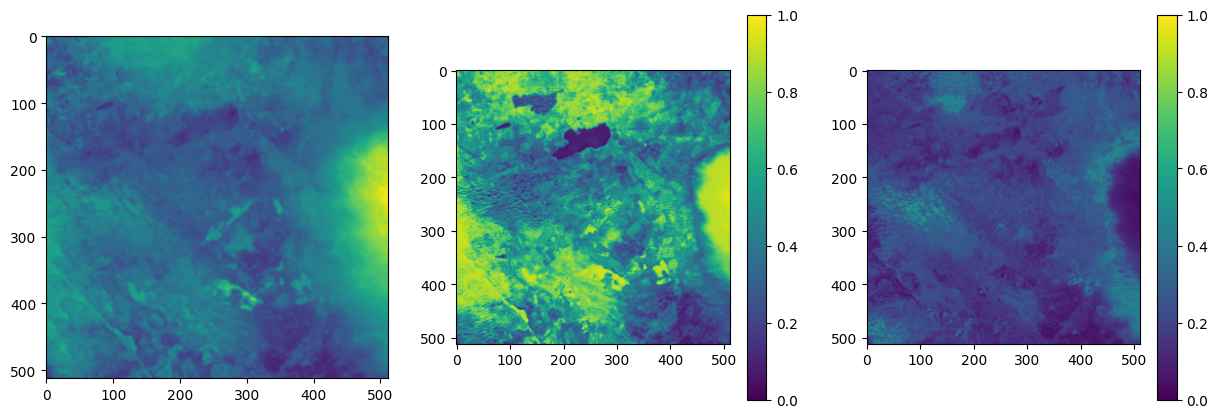

In [18]:
plt.rcParams["figure.figsize"] = [15, 5]
fig, axs=plt.subplots(ncols=3,nrows=1)
im1=axs[0].imshow(data[:,:,10],vmin=0,vmax=1)
im2=axs[1].imshow(img_pred_re[:,:,10],vmin=0,vmax=1)
im3=axs[2].imshow(uncertainty_map_re[:,:,10],vmin=0,vmax=1)

fig.colorbar(im1,ax=axs[1])
fig.colorbar(im3,ax=axs[2])

## COT estimate

In [19]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
SKIP_BAND_1=1
PROPERTY_COLUMN_MAPPING = {'spec_bands': [i for i in range(1 + SKIP_BAND_1, 14)], 'angles': [14, 15, 16], 'thick': [17], 'type': [18], 'prof_id': [19], 'gas_vapour': [20, 21], 'surf_prof': [22]}
INPUTS = ['spec_bands']
REGRESSOR = 'thick'

input_dim = np.sum([len(PROPERTY_COLUMN_MAPPING[inp]) for inp in INPUTS])
output_dim = 1

model_load_paths=['smhi_models/2023-08-10_10-33-44/model_it_2000000','smhi_models/2023-08-10_10-34-06/model_it_2000000',
                    'smhi_models/2023-08-10_10-34-18/model_it_2000000','smhi_models/2023-08-10_10-34-28/model_it_2000000',
                    'smhi_models/2023-08-10_10-34-46/model_it_2000000','smhi_models/2023-08-10_10-34-58/model_it_2000000',
                    'smhi_models/2023-08-10_10-35-09/model_it_2000000','smhi_models/2023-08-10_10-35-31/model_it_2000000',]


#model_load_paths=['cot_train/log/2024-03-14_09-11-39/model_it_2000000']

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

In [26]:
means_input_train = np.mean(in_data, axis=0)
stds_input_train = np.std(in_data, axis=0)
inputs = (in_data - means_input_train) / stds_input_train
input=torch.Tensor(inputs).to(device)

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(input)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=preds.cpu().data.numpy() #unnormalise
image_pred_cot_re=np.reshape(image_pred_cot,(x_dim,y_dim))

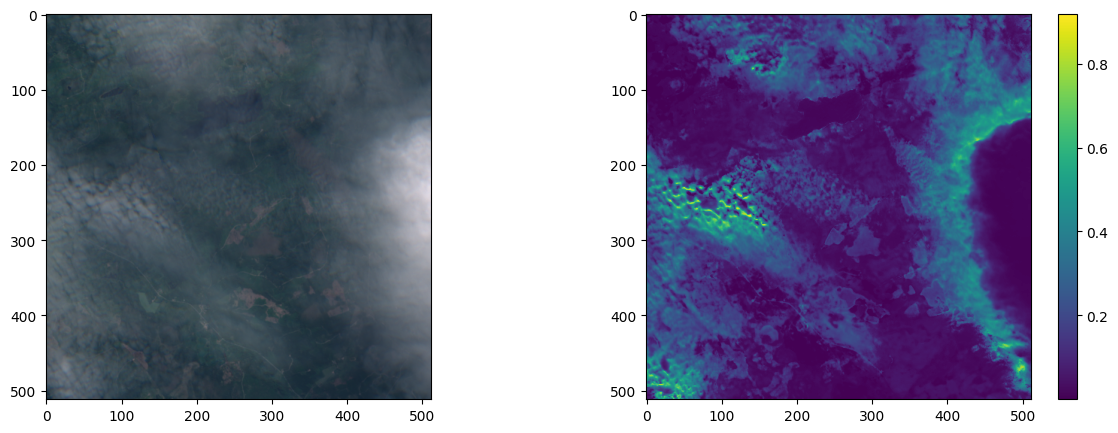

In [27]:
fig,axs =plt.subplots(ncols=2,nrows=1)
axs[0].imshow(image)
im=axs[1].imshow(image_pred_cot_re)
fig.colorbar(im,ax=axs[1])